In [1]:
import sys
import os

def configure_spark(spark_home=None, pyspark_python=None):
    spark_home = spark_home or "/path/to/default/spark/home"
    os.environ['SPARK_HOME'] = spark_home

    # Add the PySpark directories to the Python path:
    sys.path.insert(1, os.path.join(spark_home, 'python'))
    sys.path.insert(1, os.path.join(spark_home, 'python', 'pyspark'))
    sys.path.insert(1, os.path.join(spark_home, 'python', 'build'))

    # If PySpark isn't specified, use currently running Python binary:
    pyspark_python = pyspark_python or sys.executable
    os.environ['PYSPARK_PYTHON'] = pyspark_python
    
configure_spark('/usr/local/spark', '/home/ubuntu/anaconda3/envs/dat500/bin/python')

In [2]:
import argparse
import findspark
findspark.init()
import pyspark
from pyspark import SQLContext
sc = pyspark.SparkContext(master='spark://192.168.11.239:7077', appName='hourly_forecaster')
sqlContext = SQLContext(sc)

In [3]:
from datetime import datetime
import pyspark.sql.functions as F #avoid conflicts with regular python functions
from pyspark.sql.functions import udf, pandas_udf, PandasUDFType
from pyspark.sql.types import *
import pandas as pd
os.environ["ARROW_PRE_0_15_IPC_FORMAT"] = "0"
from fbprophet import Prophet
import matplotlib.pyplot as plt
from fbprophet.plot import plot_plotly
import plotly.offline as py
import holidays
import numpy as np
import time

In [4]:
def generate_US_holidays(start,end,state="IL"):
    hdays = holidays.UnitedStates(years=list(np.arange(start,end+1)),state=state).items()
    hdays = dict(list(hdays)) #Convert to dict since it is immutable
    return {str(k):v for k,v in hdays.items()} #Want Y-m-d format

us_hdays = generate_US_holidays(2001,2020)

In [5]:
@udf(StringType())
def holiday_desc(_date):
    if str(_date) in us_hdays.keys():
        return us_hdays[str(_date)]
    else:
        return "None"

In [6]:
schema = StructType([
        StructField("District", StringType(), True),
        StructField("count", StringType(), True),
        StructField("ds", DateType(), True),
        StructField("yhat", DoubleType(), True)
    ])

## Forecast data in parallel using Pandas UDFs

This strategy is heavily inspired by:
https://github.com/AlexWarembourg/Medium/blob/master/Pyspark_Pandas_UDF.ipynb

In [31]:
@pandas_udf(schema, PandasUDFType.GROUPED_MAP)
def prophet_udf(df):
    
    def train_predict_prophet(df, cutoff):
        ts_train = (df
                    .query('Timestamps <= @cutoff_point')
                    .rename(columns={'Timestamps': 'ds', 'count': 'y'})
                    .sort_values('ds')
                    )
        ts_test = (df
                   .query('Timestamps > @cutoff_point')
                   .rename(columns={'Timestamps': 'ds', 'count': 'y'})
                   .sort_values('ds')
                   .assign(ds=lambda x: pd.to_datetime(x["ds"]))
                   .drop('y', axis=1)
                   )

        m = Prophet(yearly_seasonality=4,
                    weekly_seasonality=15,
                    daily_seasonality=60
                   )
        m.fit(ts_train)
        df["Timestamps"] = pd.to_datetime(df["Timestamps"])
        
        ts_hat = (m.predict(ts_test)[["ds", "yhat"]]
                  .assign(ds=lambda x: pd.to_datetime(x["ds"]))
                  ).merge(ts_test, on=["ds"], how="left")  # merge to retrieve item and store index
        return pd.DataFrame(ts_hat, columns=schema.fieldNames())

    return train_predict_prophet(df, cutoff_point)

In [32]:
df_train = sqlContext.read.csv("/datasets/crimes.csv", header='true')\
.filter( (F.col("Year") < 2020) & (F.col("Year") >= 2016) )\
.filter( (F.col("District")!='021') & (F.col("District")!='031'))\
.withColumn('Timestamps', F.date_format(F.to_timestamp("Date", 'MM/dd/yyyy hh:mm:ss a'),"yyyy-MM-dd HH:00"))\
.withColumn('Day', F.to_date("Date", 'MM/dd/yyyy hh:mm:ss a'))\
.select("Timestamps","District")\
.groupBy("Timestamps","District")\
.count()

#We have to fill in hours with no crimes
df_train = df_train.toPandas()
df_train['Timestamps'] = df_train['Timestamps'].astype('datetime64[ns]')
df_list = []
for dist in df_train.District.unique():
    idxc = df_train[df_train.District == dist].resample('1h', on='Timestamps').sum()
    d = [dist for _ in range(0,len(idxc))]
    _tmp = pd.DataFrame(data=np.array( [idxc.index, d, idxc["count"].values]).T,\
                        columns=["Timestamps","District","count"])
    df_list.append(_tmp)
    
df_train = pd.concat(df_list,sort=False).sort_values(by = "Timestamps").reset_index(drop=True)
df_train = sqlContext.createDataFrame(df_train).dropDuplicates()



df_test = sqlContext.read.csv("/datasets/crimes.csv", header='true')\
.filter((F.col("Year") == 2020))\
.filter( (F.col("District")!='021') & (F.col("District")!='031'))\
.withColumn('Timestamps', F.date_format(F.to_timestamp("Date", 'MM/dd/yyyy hh:mm:ss a'),"yyyy-MM-dd HH:00"))\
.withColumn('Day', F.to_date("Date", 'MM/dd/yyyy hh:mm:ss a'))\
.withColumn("Month", F.month("Day"))\
.filter((F.col("Month")== 1))\
.select("Timestamps","District")\
.groupBy("Timestamps","District")\
.count()

#We have to fill in hours with no crimes
df_test = df_test.toPandas()
df_test['Timestamps'] = df_test['Timestamps'].astype('datetime64[ns]')
df_list = []
for dist in df_test.District.unique():
    idxc = df_test[df_test.District == dist].resample('1h', on='Timestamps').sum()
    d = [dist for _ in range(0,len(idxc))]
    _tmp = pd.DataFrame(data=np.array( [idxc.index, d, idxc["count"].values]).T,\
                        columns=["Timestamps","District","count"])
    df_list.append(_tmp)
    
df_test = pd.concat(df_list,sort=False).sort_values(by = "Timestamps").reset_index(drop=True)
df_test = sqlContext.createDataFrame(df_test).dropDuplicates()


print("Length of train: ", df_train.count())
print("Length of test: ", df_test.count())

cutoff_point = df_train.select(F.max(F.col('Timestamps'))).collect()[0][0]
df = (df_train.union(df_test)).sort(F.col('Timestamps'))


predictions = (df
              .groupBy("District")
              .apply(prophet_udf)
              )

start = time.time()
predictions = (predictions\
.withColumnRenamed("count","jcount")\
.withColumnRenamed("District","jDistrict"))
#Print an example from district 008
print(predictions.filter(F.col("District")=="008").show(10))
print("Predicted for all districts in ", round((time.time() - start ),2), " seconds")

Length of train:  771403
Length of test:  15821
+---------+------+----------+-------------------+
|jDistrict|jcount|        ds|               yhat|
+---------+------+----------+-------------------+
|      008|  null|2020-01-01| 1.6212456232211405|
|      008|  null|2020-01-01| 0.8180435229913208|
|      008|  null|2020-01-01| 0.6013354069329839|
|      008|  null|2020-01-01|0.46319479093537375|
|      008|  null|2020-01-01|0.36182682359187446|
|      008|  null|2020-01-01| 0.4904441422949244|
|      008|  null|2020-01-01| 0.7501569021939467|
|      008|  null|2020-01-01| 1.1386069027596708|
|      008|  null|2020-01-01| 1.5270053159093795|
|      008|  null|2020-01-01|  2.055747068228426|
+---------+------+----------+-------------------+
only showing top 10 rows

None
Predicted for all districts in  1047.78  seconds


In [33]:
predictions = df_test.join(predictions,\
              ([predictions.ds == df_test.Timestamps,\
                predictions.jDistrict == df_test.District]),\
              how='left')\
.select("Timestamps", "District","count", "yhat").dropDuplicates()

predictions.show(15)

+-------------------+--------+-----+----+
|         Timestamps|District|count|yhat|
+-------------------+--------+-----+----+
|2020-01-01 03:00:00|     025|    5|null|
|2020-01-01 04:00:00|     011|    2|null|
|2020-01-02 06:00:00|     014|    1|null|
|2020-01-02 08:00:00|     024|    0|null|
|2020-01-02 09:00:00|     001|    3|null|
|2020-01-04 07:00:00|     017|    0|null|
|2020-01-04 14:00:00|     024|    0|null|
|2020-01-06 03:00:00|     025|    0|null|
|2020-01-06 05:00:00|     022|    1|null|
|2020-01-06 06:00:00|     006|    1|null|
|2020-01-06 15:00:00|     005|    3|null|
|2020-01-06 17:00:00|     008|    3|null|
|2020-01-06 20:00:00|     006|    2|null|
|2020-01-06 23:00:00|     003|    1|null|
|2020-01-07 01:00:00|     011|    0|null|
+-------------------+--------+-----+----+
only showing top 15 rows



In [34]:
pred_df = predictions.toPandas().sort_values(by = "Timestamps").reset_index(drop=True).fillna(0)

In [35]:
pred_df = pred_df.drop_duplicates(subset=["Timestamps",'yhat'])

In [36]:
pred_df

,Timestamps,District,count,yhat
0,2020-01-01 00:00:00,022,2,0.408189
1,2020-01-01 00:00:00,017,1,0.731604
2,2020-01-01 00:00:00,017,1,1.068893
3,2020-01-01 00:00:00,017,1,0.812860
4,2020-01-01 00:00:00,017,1,0.899799
...,...,...,...,...
30868,2020-01-30 19:00:00,015,2,0.000000
30889,2020-01-30 20:00:00,019,1,0.000000
30910,2020-01-30 21:00:00,005,3,0.000000
30931,2020-01-30 22:00:00,007,1,0.000000


No handles with labels found to put in legend.


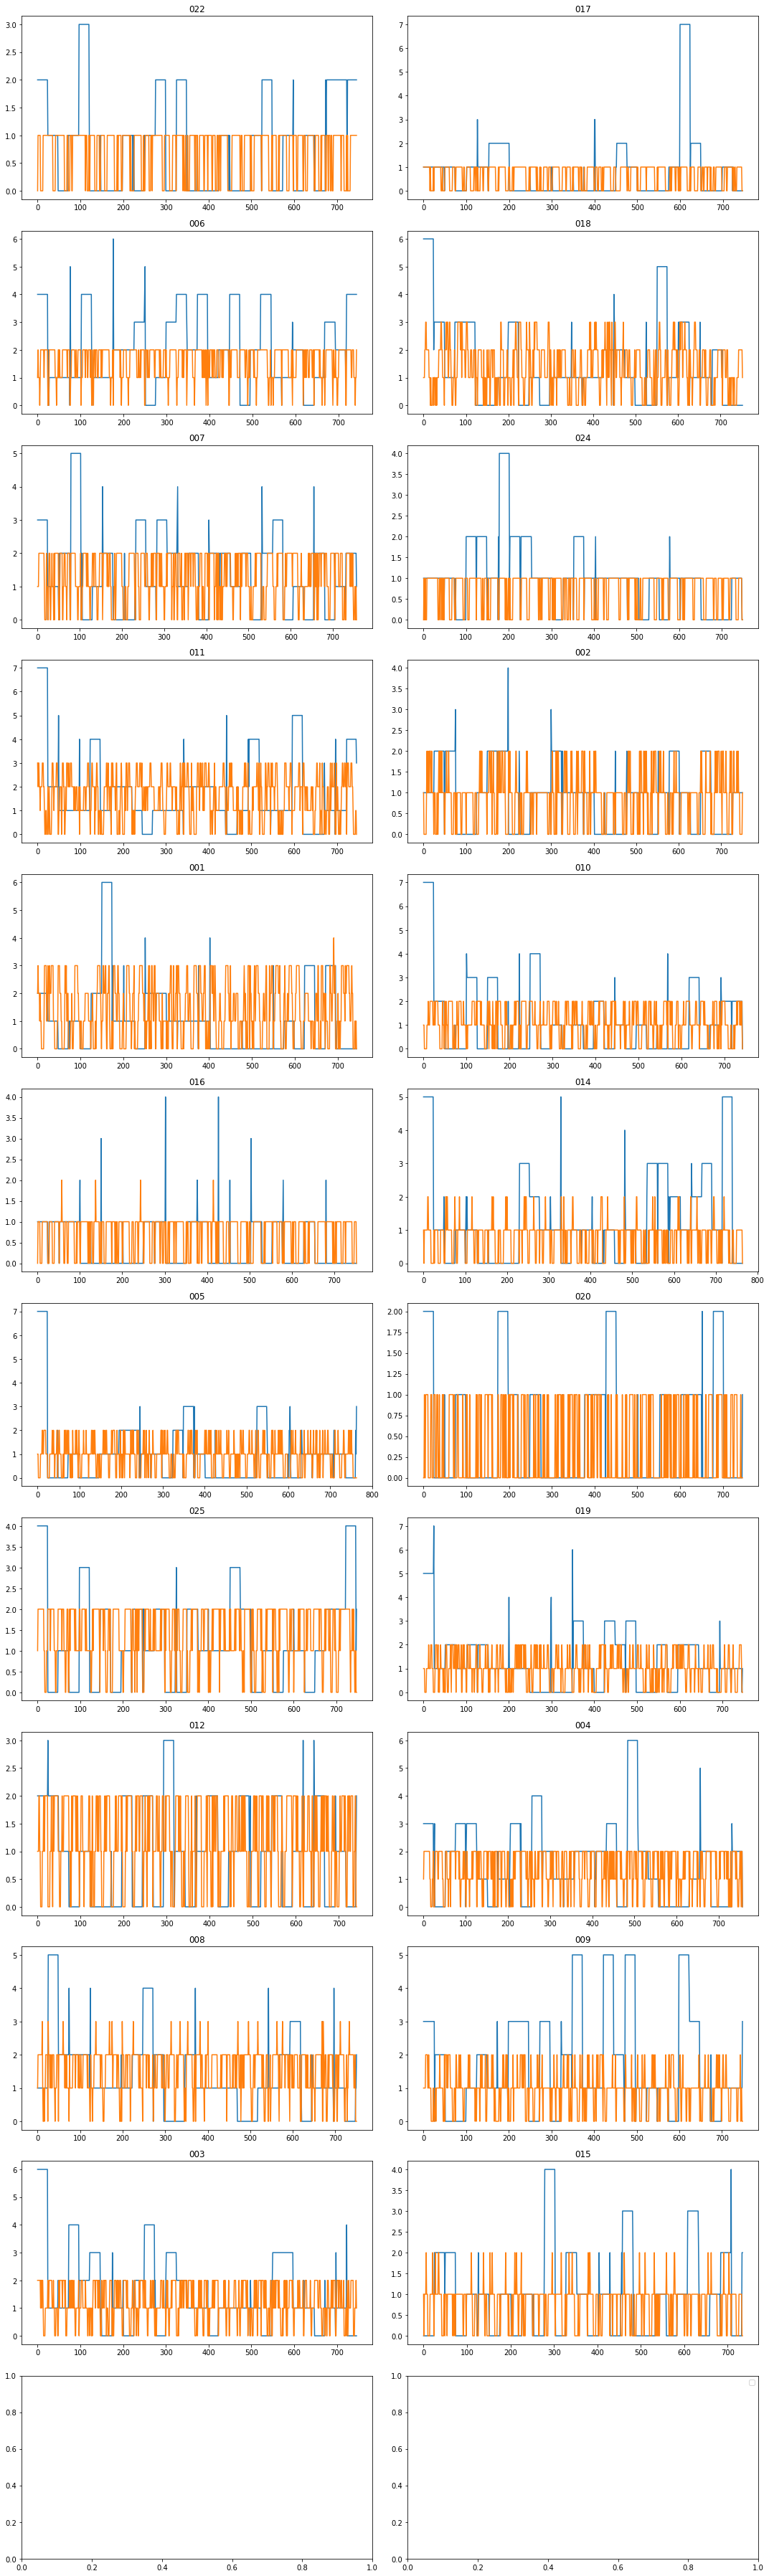

In [37]:
fig,ax = plt.subplots(12,2, sharex=False, sharey=False,figsize=(15,50))
col = 0
row = 0
init = True
for dist in pred_df.District.unique():
        col = col % 2
        if not init and col == 0:
            row = row + 1
        init = False
        
        ax[row][col].set_title(str(dist))
        for j in ["count","yhat"]:
            y = [round(x) for x in pred_df[pred_df.District == dist][j].values]
            x = np.arange(0,len(y))
            ax[row][col].plot(x, y, label=str(j))
              
        col += 1
        

plt.tight_layout()
plt.legend()
plt.show()

In [38]:
pred_df.to_csv("future_forecast",index=None)